## Clear sky insol

#### Pat OLIDRFS

https://github.com/jgcmeteo/insolation

https://www.meteoexploration.com/insol/python/insolf.html#insolf.insolation

In [1]:
# install package
import os, re
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# PAT code for MTL
file_path = '/uufs/chpc.utah.edu/common/home/skiles-group2/pnaple/DRFS-Fusion/OLI_snow_scenes/LC08_L2SP_034032_20150126_20200909_02_T1_MTL.txt'

# Open and read the file
with open(file_path, 'r') as file:
    lines = file.readlines()
    
# Look for the line containing "SUN_ELEVATION"
sun_elevation = None
for line in lines:
    if "SUN_ELEVATION" in line:
        sun_elevation = line.split('=')[-1].strip()
        
# Output the Sun Elevation
print(f"Sun Elevation: {sun_elevation}")

Sun Elevation: 27.22098727


In [3]:
# file paths
# pattern = "*MTL.txt"
path_main = os.listdir('/uufs/chpc.utah.edu/common/home/skiles-group2/pnaple/drfs/clipped_geotiffs/')
# print(path_main)
# os.path.join(path_main, "masked_geotiffs")

In [4]:
# test one file
# dataset = gdal.Open('/uufs/chpc.utah.edu/common/home/skiles-group2/pnaple/drfs/clipped_geotiffs/UCRB_20090401.tif')
# dataset = gdal.Open('/uufs/chpc.utah.edu/common/home/skiles-group2/pnaple/drfs/masked_geotiffs/UCRB_20090401.tif')
dataset = gdal.Open('/uufs/chpc.utah.edu/common/home/skiles-group2/pnaple/drfs/masked_geotiffs/UCRB_20090401.tif')

dataset.RasterCount
# dataset.GetMetadata()

3

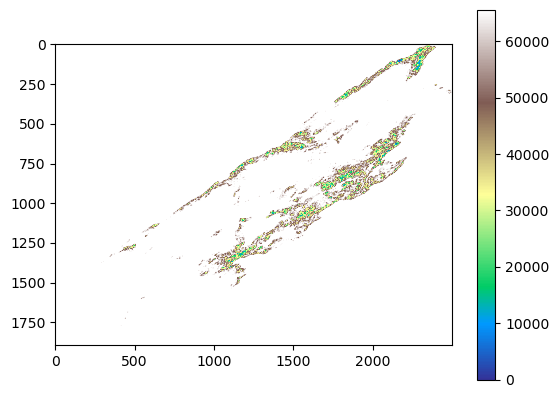

In [5]:
# Read the data into a numpy array
band = dataset.GetRasterBand(1)  # 1 Grain size? 3 DEM
data = band.ReadAsArray()

# Plot the data
plt.imshow(data, cmap="terrain")  # Choose an appropriate colormap

plt.colorbar()
plt.show()

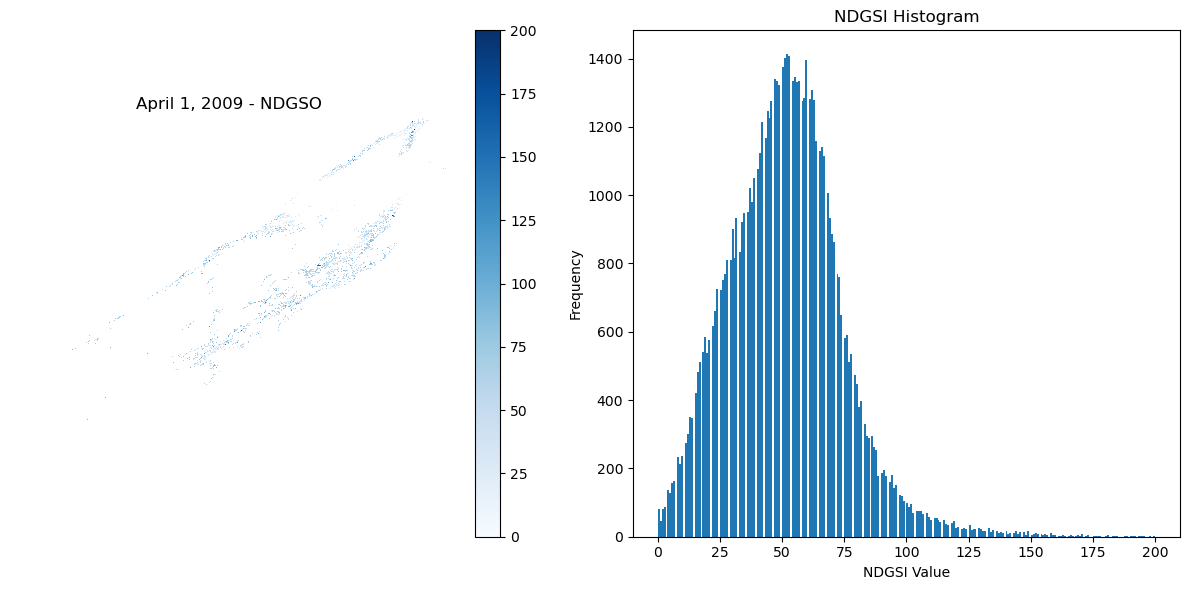

In [6]:
# Assuming `array` is already loaded from the raster band as you've done:
band = dataset.GetRasterBand(1)
array = band.ReadAsArray()

# Replace values over 60000 with NaN
array[array > 200] = np.nan

# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the image on the first subplot
# Use masked array to properly handle NaN values in the image
masked_array = np.ma.masked_invalid(array)
im = axes[0].imshow(masked_array, cmap='Blues', interpolation='none', vmin=np.nanmin(array), vmax=np.nanmax(array))
axes[0].set_title("April 1, 2009 - NDGSO")
axes[0].axis('off')  # Turn off axis labels for cleaner display
fig.colorbar(im, ax=axes[0])  # Add color bar to the image

# Plot the histogram on the second subplot
# Exclude NaN values from the histogram calculation
axes[1].hist(array[~np.isnan(array)].ravel(), bins=256, range=(np.nanmin(array), np.nanmax(array)))
axes[1].set_title('NDGSI Histogram')
axes[1].set_xlabel('NDGSI Value')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


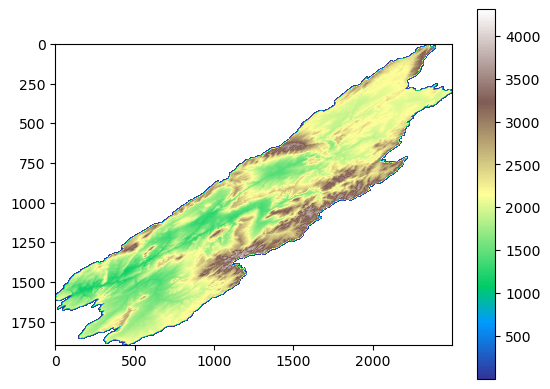

In [7]:
# PLOT DEM
band = dataset.GetRasterBand(3)  # 1 Grain size? 3 DEM
data = band.ReadAsArray()

cmap = plt.cm.terrain
cmap.set_under('white', alpha=0)

# Display the image with transparent 0 values
plt.imshow(data, cmap=cmap, vmin=0.001)

plt.colorbar()
plt.show()

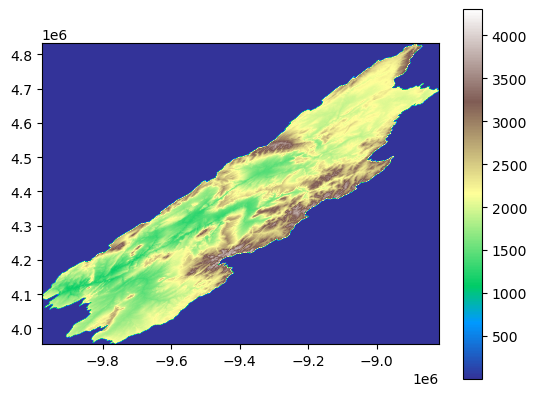

In [8]:
# plot DEM
# Read the data from the first band
band = dataset.GetRasterBand(3)
data = band.ReadAsArray()

# Get the geotransform information
geotransform = dataset.GetGeoTransform()

# Plot the data
plt.imshow(data, cmap='terrain', vmin = 1, extent=[geotransform[0], geotransform[0] + geotransform[1] * dataset.RasterXSize,
                                      geotransform[3] + geotransform[5] * dataset.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

In [9]:
## 2. Reproject (warp)
import random
# extract epsg code from dem
epsg_code = "EPSG:4326"

# temp file
mem_hrrr_file = '/vsimem/grib_%i.tif' % random.getrandbits(32)

# warp options for topo files
options = gdal.WarpOptions(
            dstSRS=epsg_code,
            outputBoundsSRS=epsg_code,
            outputBounds= [-112.5, 35.5, -105.5, 43.5],
            # xRes=topo1.GetGeoTransform()[1],
            # yRes=topo1.GetGeoTransform()[1],
            multithread=True,
        )

# warp file, original, options=topo1
gdal.Warp(mem_hrrr_file, dataset, options=options)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f54b0019f20> >

In [10]:
## 3.5 reopen (save)
ucrb1 = gdal.Open(mem_hrrr_file, gdal.GA_ReadOnly)
ucrb1

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f54b02cbd80> >

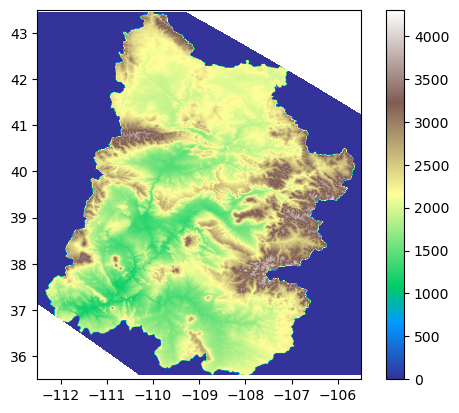

In [11]:
# plot warped
band_warp = ucrb1.GetRasterBand(3) # DEM
data_warp = band_warp.ReadAsArray()

# Get the geotransform information
geotransform = ucrb1.GetGeoTransform()

# Plot the data
plt.figure()
plt.imshow(data_warp, cmap='terrain', extent=[geotransform[0], geotransform[0] + geotransform[1] * ucrb1.RasterXSize,
                                      geotransform[3] + geotransform[5] * ucrb1.RasterYSize, geotransform[3]])
plt.colorbar()
plt.show()

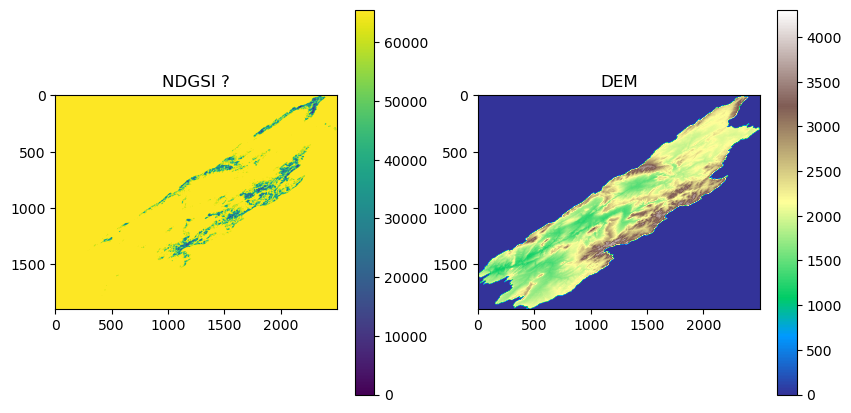

In [12]:
# plot side-by-side
band_ndg = dataset.GetRasterBand(1)
data_ndg = band_ndg.ReadAsArray()
band_dem = dataset.GetRasterBand(3)
data_dem = band_dem.ReadAsArray()
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot raster data and store the returned image object
im1 = axs[0].imshow(data_ndg, cmap='viridis')
axs[0].set_title('NDGSI ?')

im2 = axs[1].imshow(data_dem, cmap='terrain')
axs[1].set_title('DEM')

# Add colorbars
fig.colorbar(im1, ax=axs[0])  # Colorbar for the first subplot
fig.colorbar(im2, ax=axs[1])  # Colorbar for the second subplot

plt.show()

In [13]:
# retreive all angles
# geemap - extract DEM
# terrain parameters
# solar geometries
# calculate clear sky